In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production


100%|██████████| 884k/884k [00:00<00:00, 89.3MB/s]

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Bidirectional
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [4]:
# Load the data
df = pd.read_csv('/content/hourly-electricity-consumption-and-production/electricityConsumptionAndProductioction.csv')
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [5]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
Consumption,46011.000000,6587.616440,1043.654923,3889.000000,3889.000000,5773.000000,5938.000000,6552.000000,7321.000000,7509.000000,9615.000000,9615.000000
Production,46011.000000,6518.645628,986.805018,3315.000000,3315.000000,5814.000000,5962.000000,6462.000000,7176.000000,7358.000000,9886.000000,9886.000000
Nuclear,46011.000000,1291.177501,236.549637,562.000000,562.000000,1347.000000,1356.000000,1383.000000,1405.000000,1410.000000,1457.000000,1457.000000
Wind,46011.000000,792.310882,675.812712,-26.000000,-26.000000,236.000000,297.000000,592.000000,1205.000000,1394.000000,2811.000000,2811.000000
Hydroelectric,46011.000000,1857.052444,692.592157,175.000000,175.000000,1347.000000,1438.000000,1747.000000,2265.000000,2405.000000,4434.000000,4434.000000
Oil and Gas,46011.000000,1171.890418,434.748917,198.000000,198.000000,858.000000,937.000000,1211.000000,1511.000000,1611.000000,2141.000000,2141.000000
Coal,46011.000000,1193.157332,320.449368,279.000000,279.000000,962.000000,1008.000000,1172.000000,1406.000000,1467.000000,2537.000000,2537.000000
Solar,46011.000000,156.688031,229.502650,0.000000,0.000000,0.000000,0.000000,2.000000,280.000000,370.000000,1137.000000,1137.000000
Biomass,46011.000000,55.851862,14.235554,17.000000,17.000000,45.000000,48.000000,57.000000,67.000000,68.000000,89.000000,89.000000


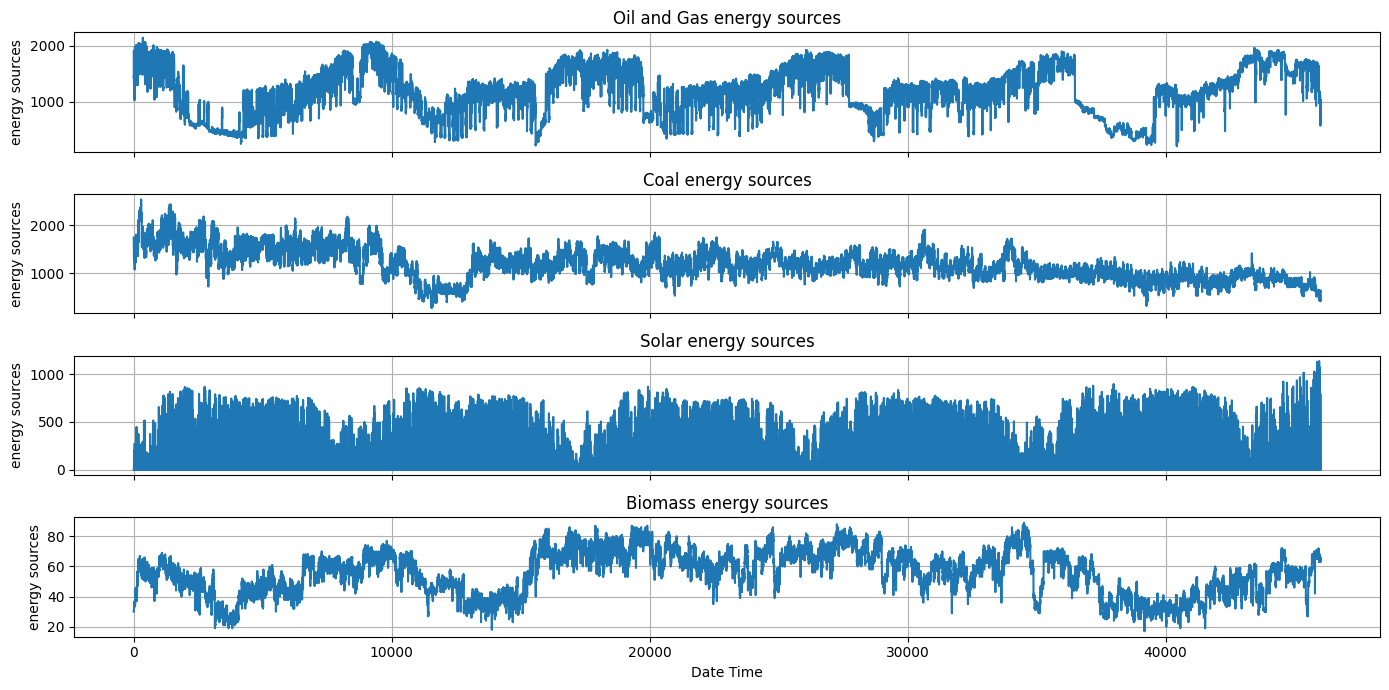

In [7]:
import matplotlib.pyplot as plt

# Define the energy sources of interest
energy_sources = ['Oil and Gas', 'Coal', 'Solar', 'Biomass']

# Create subplots for the selected energy sources
fig, axes = plt.subplots(nrows=len(energy_sources), ncols=1, figsize=(14, 7), sharex=True)

# Plot each energy source in its own subplot
for i, source in enumerate(energy_sources):
    axes[i].plot(df.index, df[source], label=source)
    axes[i].set_ylabel('energy sources')
    axes[i].set_title(f'{source} energy sources')
    axes[i].grid(True)

# Set common x-axis label and adjust layout
plt.xlabel('Date Time')
plt.tight_layout()
plt.show()


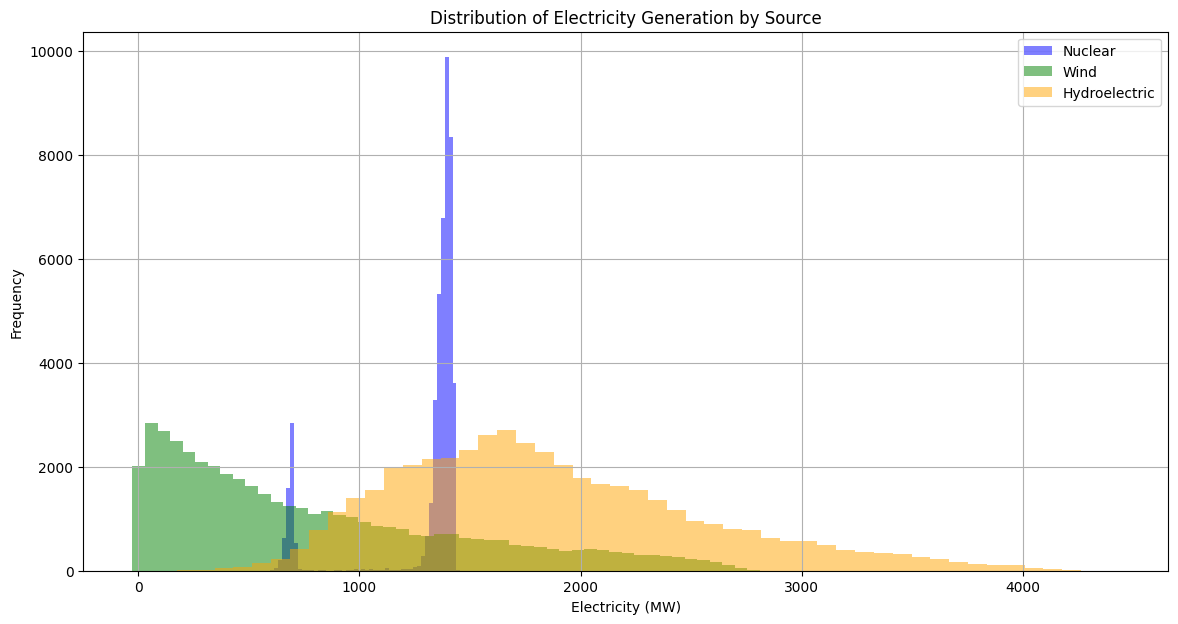

In [8]:
plt.figure(figsize=(14, 7))

plt.hist(df['Nuclear'], bins=50, alpha=0.5, label='Nuclear', color='blue')
plt.hist(df['Wind'], bins=50, alpha=0.5, label='Wind', color='green')
plt.hist(df['Hydroelectric'], bins=50, alpha=0.5, label='Hydroelectric', color='orange')

plt.xlabel('Electricity (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Electricity Generation by Source')
plt.legend()
plt.grid(True)
plt.show()

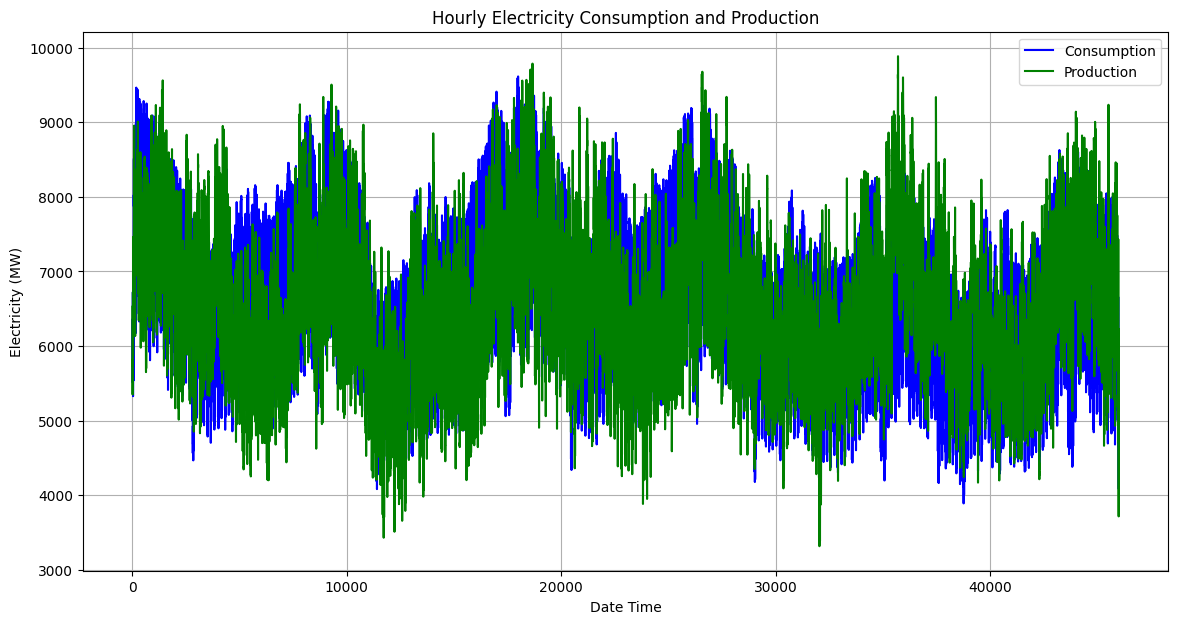

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Consumption'], label='Consumption', color='blue')
plt.plot(df.index, df['Production'], label='Production', color='green')

plt.xlabel('Date Time')
plt.ylabel('Electricity (MW)')
plt.title('Hourly Electricity Consumption and Production')
plt.legend()
plt.grid(True)
plt.show()

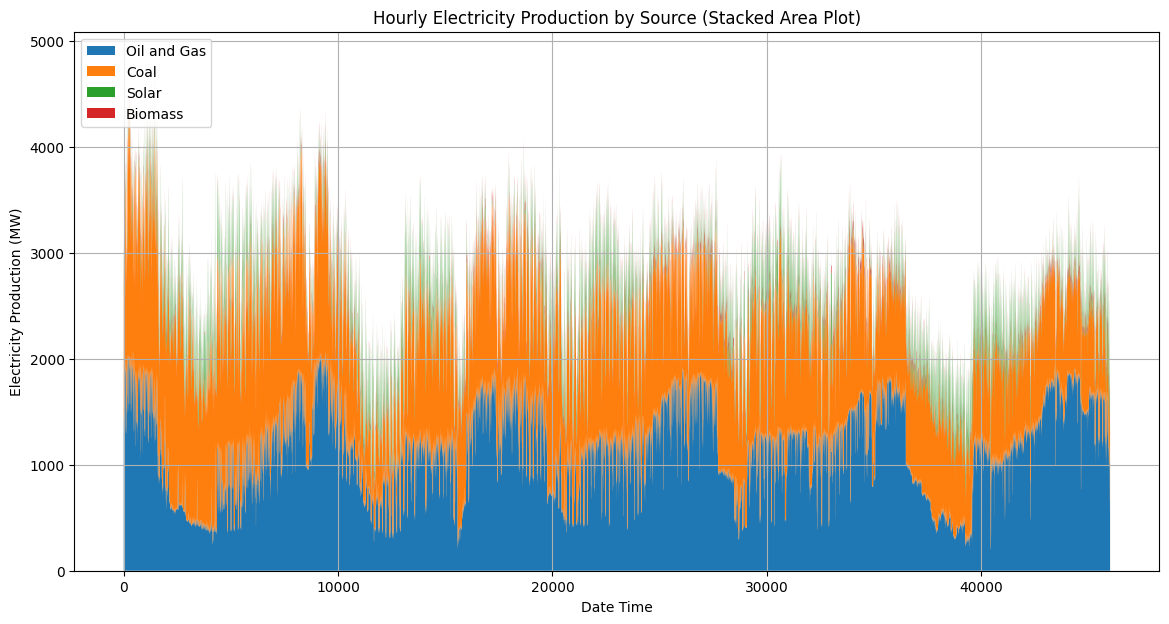

In [10]:
plt.figure(figsize=(14, 7))

plt.stackplot(df.index, [df[source] for source in energy_sources], labels=energy_sources)

plt.xlabel('Date Time')
plt.ylabel('Electricity Production (MW)')
plt.title('Hourly Electricity Production by Source (Stacked Area Plot)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [11]:
# Convert the 'DateTime' column to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

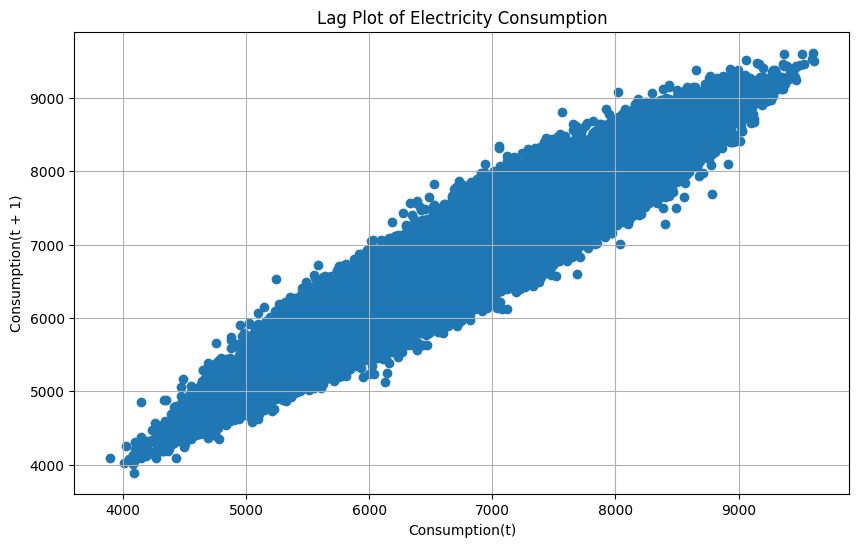

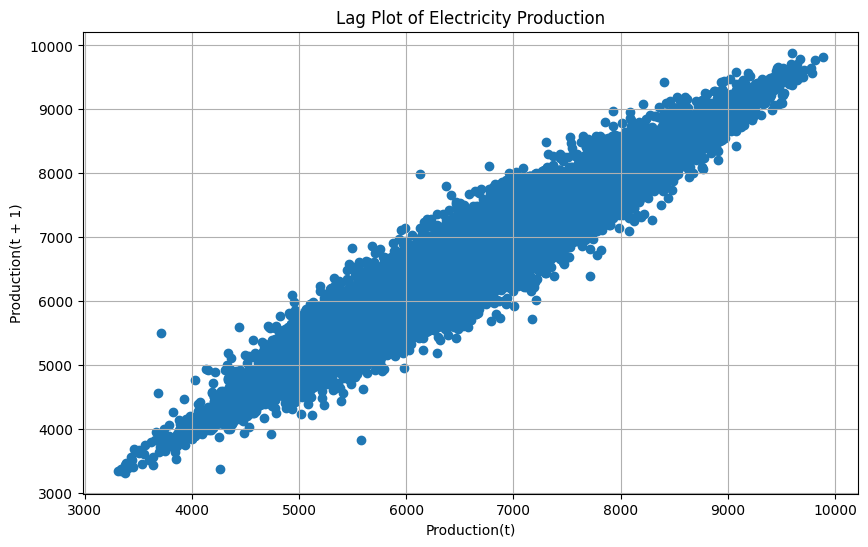

In [12]:
plt.figure(figsize=(10, 6))
lag_plot(df['Consumption'])
plt.title('Lag Plot of Electricity Consumption')
plt.xlabel('Consumption(t)')
plt.ylabel('Consumption(t + 1)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
lag_plot(df['Production'])
plt.title('Lag Plot of Electricity Production')
plt.xlabel('Production(t)')
plt.ylabel('Production(t + 1)')
plt.grid(True)
plt.show()

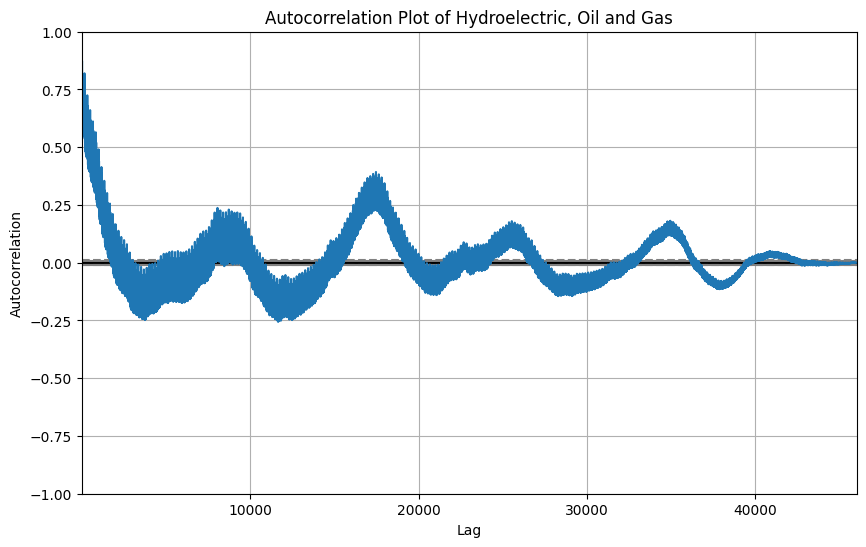

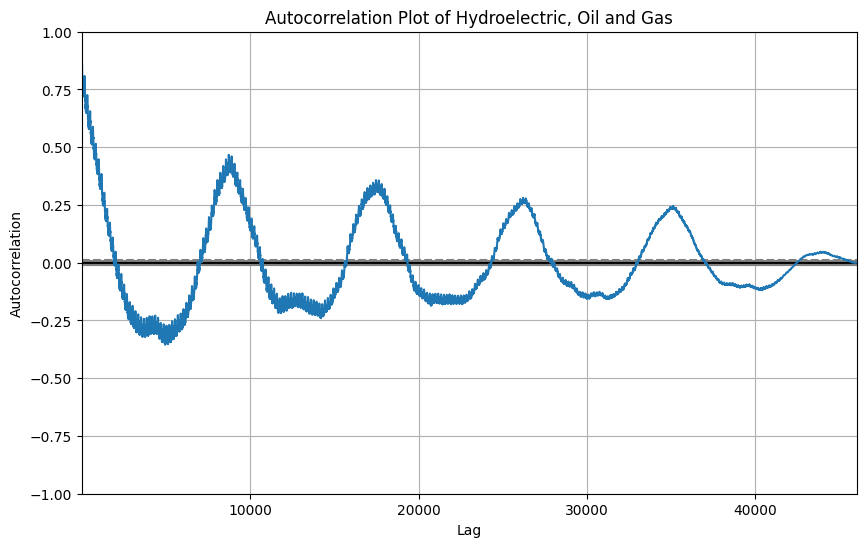

In [13]:
plt.figure(figsize=(10, 6))
autocorrelation_plot(df['Hydroelectric'])
plt.title('Autocorrelation Plot of Hydroelectric, Oil and Gas')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
autocorrelation_plot(df['Oil and Gas'])
plt.title('Autocorrelation Plot of Hydroelectric, Oil and Gas')
plt.grid(True)
plt.show()

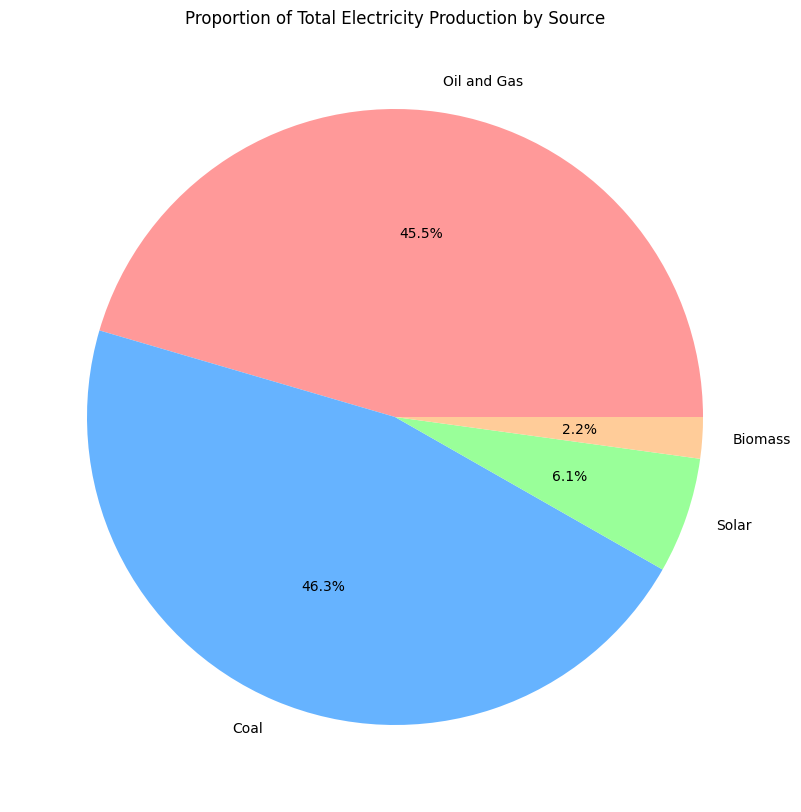

In [14]:
total_production_by_source = df[energy_sources].sum()

plt.figure(figsize=(10, 10))
total_production_by_source.plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c4e17f'])

plt.ylabel('')
plt.title('Proportion of Total Electricity Production by Source')
plt.show()

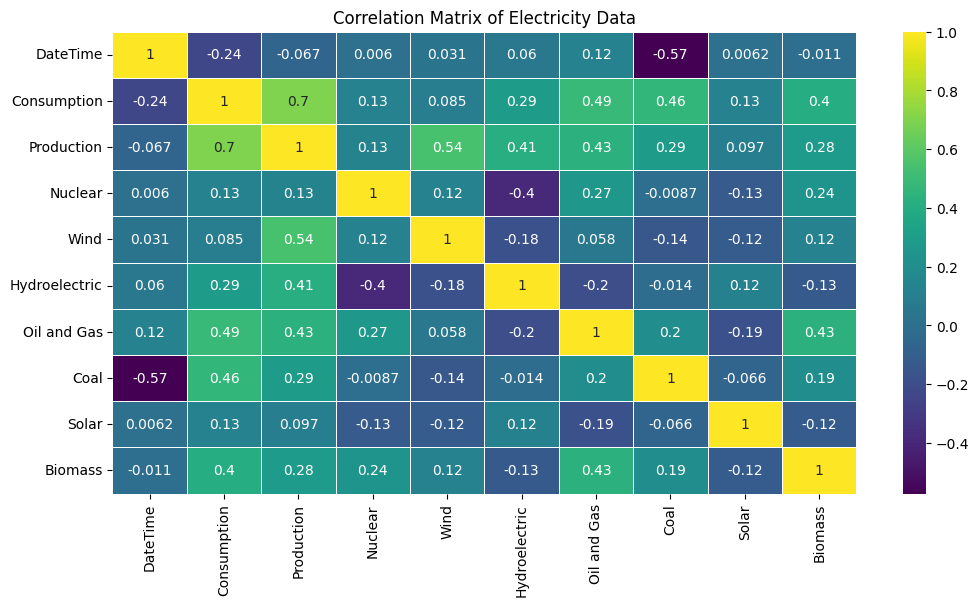

In [15]:
plt.figure(figsize=(12, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Electricity Data')
plt.show()

In [16]:
# Normalize the data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])

# Convert to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'])

# Create sequences
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

# Simple RNN Model Definition
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    SimpleRNN(50),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Simple RNN Model Training
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Simple RNN Model Evaluation
rnn_predictions = rnn_model.predict(X_test)

# Calculate evaluation metrics for Simple RNN
rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)


print(f'Simple RNN - R² Score: {rnn_r2}')
print(f'Simple RNN - Mean Absolute Error (MAE): {rnn_mae}')
print(f'Simple RNN - Mean Squared Error (MSE): {rnn_mse}')
print(f'Simple RNN - Root Mean Squared Error (RMSE): {rnn_rmse}')


Epoch 1/20
920/920 [==============================] - 17s 16ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 2/20
920/920 [==============================] - 12s 14ms/step - loss: 0.0011 - val_loss: 7.9971e-04
Epoch 3/20
920/920 [==============================] - 14s 16ms/step - loss: 9.4360e-04 - val_loss: 7.8129e-04
Epoch 4/20
920/920 [==============================] - 14s 15ms/step - loss: 7.8746e-04 - val_loss: 7.2762e-04
Epoch 5/20
920/920 [==============================] - 15s 16ms/step - loss: 8.1653e-04 - val_loss: 6.6913e-04
Epoch 6/20
920/920 [==============================] - 13s 14ms/step - loss: 7.6682e-04 - val_loss: 6.3991e-04
Epoch 7/20
920/920 [==============================] - 17s 18ms/step - loss: 7.1802e-04 - val_loss: 0.0010
Epoch 8/20
920/920 [==============================] - 13s 14ms/step - loss: 6.6548e-04 - val_loss: 5.8683e-04
Epoch 9/20
920/920 [==============================] - 22s 24ms/step - loss: 6.4408e-04 - val_loss: 7.9922e-04
Epoch 10/20
920/920 [=====

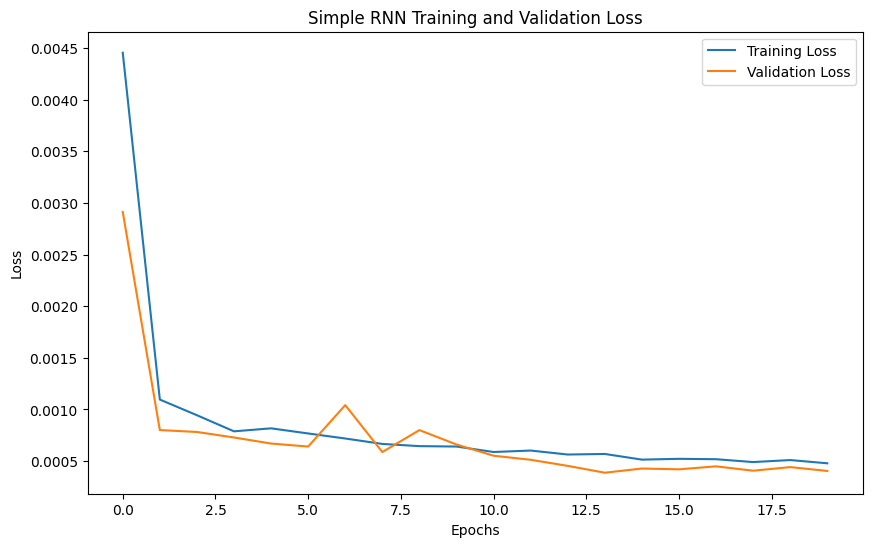

In [17]:
# Simple RNN
plt.figure(figsize=(10,6))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

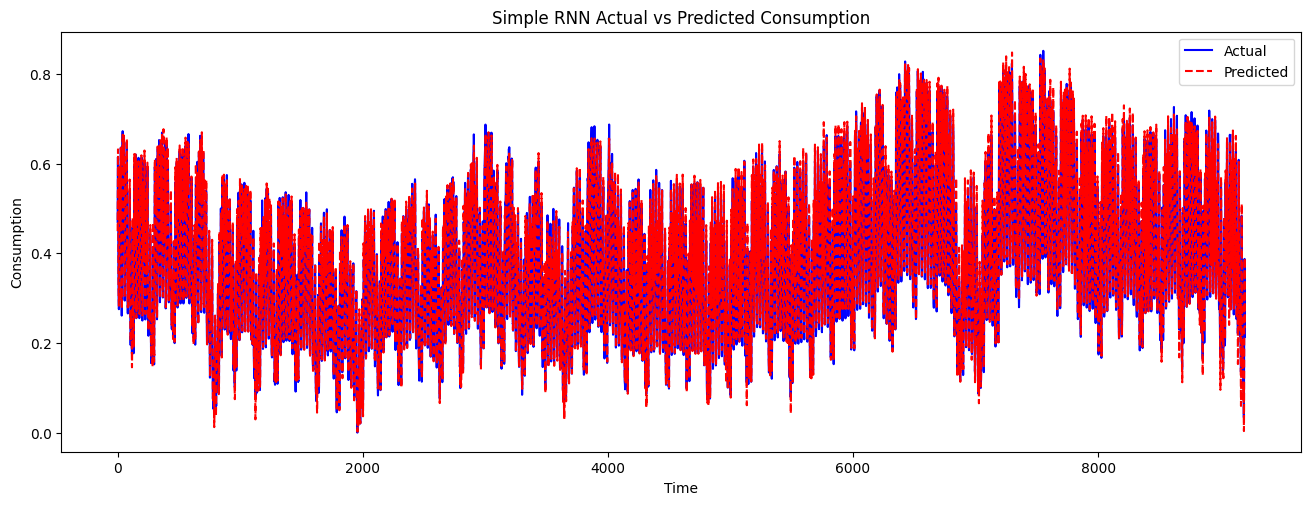

In [18]:
plt.figure(figsize=(16, 12))
# Simple RNN
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(rnn_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('Simple RNN Actual vs Predicted Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

In [19]:
# Feature Engineering: Add time-based features
df['hour'] = pd.to_datetime(df['DateTime']).dt.hour
df['dayofweek'] = pd.to_datetime(df['DateTime']).dt.dayofweek

# Normalize the data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'hour', 'dayofweek']])

# Convert to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'hour', 'dayofweek'])

# Create sequences
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence

sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

# Model Definition
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Model Training
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])


# Model Evaluation
predictions = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/30
920/920 [==============================] - 33s 30ms/step - loss: 0.0105 - val_loss: 0.0022 - lr: 0.0010
Epoch 2/30
920/920 [==============================] - 25s 28ms/step - loss: 0.0037 - val_loss: 0.0018 - lr: 0.0010
Epoch 3/30
920/920 [==============================] - 25s 28ms/step - loss: 0.0026 - val_loss: 0.0013 - lr: 0.0010
Epoch 4/30
920/920 [==============================] - 25s 27ms/step - loss: 0.0020 - val_loss: 9.0690e-04 - lr: 0.0010
Epoch 5/30
920/920 [==============================] - 24s 26ms/step - loss: 0.0016 - val_loss: 8.2971e-04 - lr: 0.0010
Epoch 6/30
920/920 [==============================] - 25s 28ms/step - loss: 0.0013 - val_loss: 6.5727e-04 - lr: 0.0010
Epoch 7/30
920/920 [==============================] - 30s 33ms/step - loss: 0.0011 - val_loss: 5.0699e-04 - lr: 0.0010
Epoch 8/30
920/920 [==============================] - 25s 28ms/step - loss: 0.0010 - val_loss: 5.2429e-04 - lr: 0.0010
Epoch 9/30
920/920 [==============================] - 26s 28

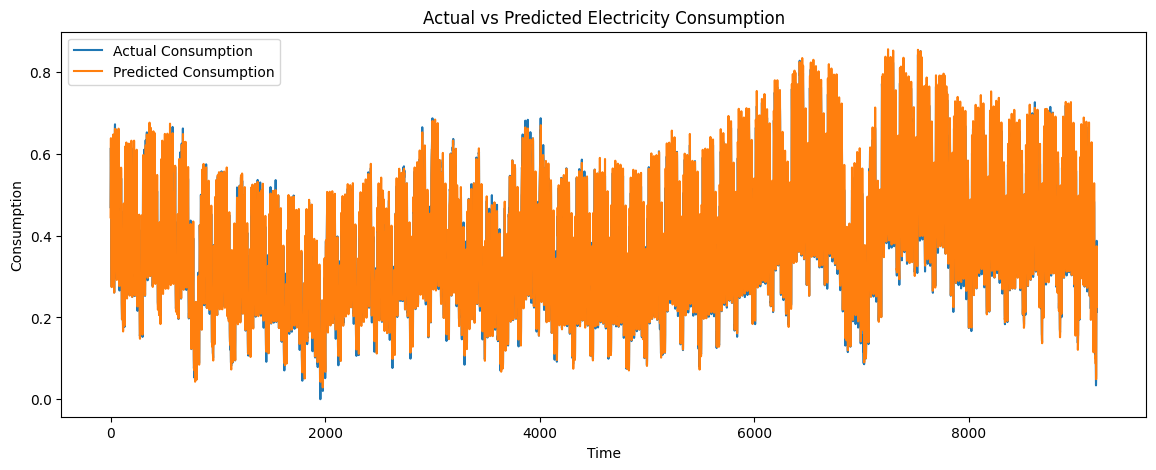

In [20]:
# Plot predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual Consumption')
plt.plot(predictions, label='Predicted Consumption')
plt.title('Actual vs Predicted Electricity Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()

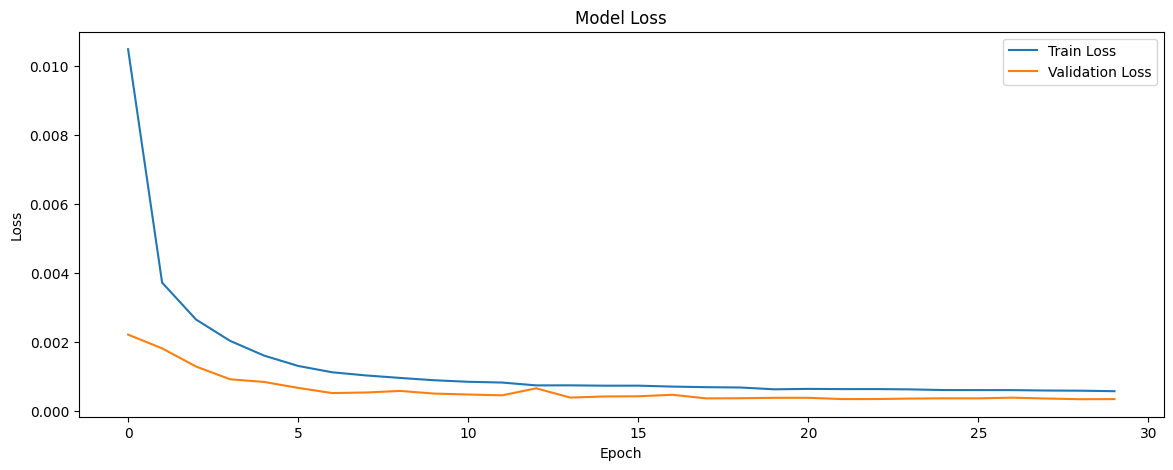

In [21]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()